In [1]:
import pandas as pd

def load_data(pid, condition):
    file_path = f"interactions/p{pid}/{condition}.json"
    data = pd.read_json(file_path)
    # add id and condition columns
    data['pid'] = pid
    data['condition'] = condition
    # extract section_id from each row in 'data' column
    def extract_section_id(row):
        if isinstance(row, dict):
            return row.get('section_id', None)
    data['section_id'] = data['data'].apply(extract_section_id)
    data['has_section_id'] = data['section_id'].notnull()
    return data

# combine all data into a single dataframe
df_all = pd.DataFrame()
for pid in range(1, 13):
    for condition in ["pasta", "naturaledit"]:
        df = load_data(pid, condition)
        df_all = pd.concat([df_all, df], ignore_index=True)

In [2]:
unique_counts = df_all.groupby(['condition', 'source', 'event', 'has_section_id']).size().reset_index(name='count')
unique_counts = unique_counts.sort_values(by=['condition', 'source', 'event', 'has_section_id']).reset_index(drop=True)
unique_counts

,condition,source,event,has_section_id,count
0,naturaledit,backend,apply_instruction_summary,False,50
1,naturaledit,backend,map_summary_code,False,758
2,naturaledit,backend,modify_direct_instruction,False,8
3,naturaledit,backend,modify_summary_mediation,False,51
4,naturaledit,backend,summarize_modified_code,False,59
5,naturaledit,backend,summarize_selected_code,False,68
6,naturaledit,frontend,apply_instruction_summary,True,50
7,naturaledit,frontend,autotransit_section,False,123
8,naturaledit,frontend,change_summary_level,True,256
9,naturaledit,frontend,click_edit_in_prompt,True,70


In [3]:
from graphviz import Digraph
from collections import Counter
from IPython.display import SVG, display

def plot_event_transition_graph(df, output_path):
    """
    Plot an event transition graph from a DataFrame of events.

    Parameters
    ----------
    df : pandas.DataFrame
        Must contain an 'event' column in sequential order.
    output_path : str
        Path to save the SVG output, e.g., 'figures/event_transition_graph.svg'.
    """

    # Build event transition pairs
    transitions = []
    for i in range(len(df) - 1):
        event_from = df.iloc[i]['event']
        event_to = df.iloc[i + 1]['event']
        transitions.append((event_from, event_to))

    # Count transitions
    transition_counts = Counter(transitions)
    transition_counts = {k: v for k, v in transition_counts.items() 
                         if (k[0] != k[1] 
                             and k[1] != 'generate_summary_section'
                             and v > 1)}

    # Count event occurrences for node labels
    event_counts = Counter(df['event'])

    print("Event Counts:", event_counts)
    print("Transition Counts:", transition_counts)

    # Create directed graph using graphviz
    dot = Digraph(comment='Event Transition Graph')
    for event, count in event_counts.items():
        dot.node(event, label=f"{event}\n{count}")
    for (event_from, event_to), count in transition_counts.items():
        dot.edge(event_from, event_to, label=str(count))

    # Render and save the graph as SVG
    svg_data = dot.pipe(format='svg')
    with open(output_path, 'wb') as f:
        f.write(svg_data)

    # Display inline
    # display(SVG(svg_data))

    return event_counts, transition_counts

## NaturalEdit

In [4]:
interactions_naturealedit = df_all.copy()
interactions_naturealedit = interactions_naturealedit[interactions_naturealedit['condition'] == 'naturaledit'].reset_index(drop=True)
interactions_naturealedit = interactions_naturealedit[interactions_naturealedit['source'] == 'frontend'].reset_index(drop=True)

In [5]:
import pandas as pd
# Convert timestamp to datetime
interactions_naturealedit['timestamp'] = pd.to_datetime(interactions_naturealedit['timestamp'])
merged_rows = []
i = 0
while i < len(interactions_naturealedit):
    row = interactions_naturealedit.iloc[i]
    if row['event'] == 'mapping_hover':
        start_time = row['timestamp']
        # Find consecutive mapping_hover and mapping_unhover events
        while i + 1 < len(interactions_naturealedit) and interactions_naturealedit.iloc[i + 1]['event'] in ['mapping_hover', 'mapping_unhover']:
            i += 1
        end_time = interactions_naturealedit.iloc[i]['timestamp']
        duration = (end_time - start_time).total_seconds()
        if duration > 0:
            merged_row = row.copy()
            merged_row['event'] = 'inspect_mapping'
            # Write duration into the data dict
            if isinstance(merged_row['data'], dict):
                merged_row['data']['duration'] = duration
            merged_rows.append(merged_row)
    else:
        merged_rows.append(row)
    i += 1
interactions_naturealedit_updated = pd.DataFrame(merged_rows)
interactions_naturealedit_updated = interactions_naturealedit_updated[~interactions_naturealedit_updated['event'].isin(['mapping_hover', 'mapping_unhover'])].reset_index(drop=True)

In [6]:
# Merge consecutive change_summary_level events, keep first before and last after in data
merged_change_rows = []
i = 0
while i < len(interactions_naturealedit_updated):
    row = interactions_naturealedit_updated.iloc[i]
    if row['event'] == 'change_summary_level':
        start_idx = i
        start_row = row
        # Find consecutive change_summary_level events
        while i + 1 < len(interactions_naturealedit_updated) and interactions_naturealedit_updated.iloc[i + 1]['event'] == 'change_summary_level':
            i += 1
        end_idx = i
        end_row = interactions_naturealedit_updated.iloc[end_idx]
        merged_row = start_row.copy()
        if isinstance(merged_row['data'], dict) and isinstance(end_row['data'], dict):
            merged_row['data']['before_detail_level'] = start_row['data'].get('before_detail_level')
            merged_row['data']['before_structured'] = start_row['data'].get('before_structured')
            merged_row['data']['after_detail_level'] = end_row['data'].get('after_detail_level')
            merged_row['data']['after_structured'] = end_row['data'].get('after_structured')
        merged_row['timestamp'] = start_row['timestamp']
        merged_change_rows.append(merged_row)
    else:
        merged_change_rows.append(row)
    i += 1
interactions_naturealedit_updated = pd.DataFrame(merged_change_rows).reset_index(drop=True)

In [7]:
# Remove frontend/toggle_section with after_section_id None
mask = ~((interactions_naturealedit_updated['source'] == 'frontend') & (interactions_naturealedit_updated['event'] == 'toggle_section') & (interactions_naturealedit_updated['data'].apply(lambda d: isinstance(d, dict) and d.get('after_section_id') is None)))
filtered_toggle_df = interactions_naturealedit_updated[mask].reset_index(drop=True)
# Merge consecutive frontend/toggle_section events
merged_toggle_rows = []
i = 0
while i < len(filtered_toggle_df):
    row = filtered_toggle_df.iloc[i]
    if row['source'] == 'frontend' and row['event'] == 'toggle_section':
        start_row = row
        # Find consecutive toggle_section events
        while i + 1 < len(filtered_toggle_df):
            next_row = filtered_toggle_df.iloc[i + 1]
            if next_row['source'] == 'frontend' and next_row['event'] == 'toggle_section':
                i += 1
            else:
                break
        end_row = filtered_toggle_df.iloc[i]
        merged_row = start_row.copy()
        if isinstance(end_row['data'], dict):
            merged_row['data']['after_section_id'] = end_row['data'].get('after_section_id')
            merged_row['section_id'] = end_row['data'].get('after_section_id')
            merged_row['has_section_id'] = merged_row['section_id'] is not None
        if merged_row['data']['after_section_id'] != merged_row['data']['before_section_id']:
            merged_toggle_rows.append(merged_row)
    else:
        merged_toggle_rows.append(row)
    i += 1
interactions_naturealedit_updated = pd.DataFrame(merged_toggle_rows).reset_index(drop=True)
interactions_naturealedit_updated

,source,event,data,timestamp,id,pid,condition,section_id,has_section_id
0,frontend,click_summarize_code,{},2025-08-16 22:49:05,MRGR4deCIV9B8VxoJnha,1,naturaledit,None,False
1,frontend,autotransit_section,"{'before_section_id': None, 'after_section_id'...",2025-08-16 22:49:14,GN6QdAOrUknup68408HU,1,naturaledit,None,False
2,frontend,create_new_section,{'section_id': '94e232d8-8f75-4045-a81c-fb03a7...,2025-08-16 22:49:14,h3PKq91PNm0YHaHPEIfg,1,naturaledit,94e232d8-8f75-4045-a81c-fb03a7b3aacc,True
3,frontend,inspect_mapping,{'section_id': '94e232d8-8f75-4045-a81c-fb03a7...,2025-08-16 22:49:20,RXQTNfp2oI0gpLxKMld0,1,naturaledit,94e232d8-8f75-4045-a81c-fb03a7b3aacc,True
4,frontend,change_summary_level,"{'before_detail_level': 'medium', 'section_id'...",2025-08-16 22:49:25,7JGUaFR7v9EjRyPEb6JK,1,naturaledit,94e232d8-8f75-4045-a81c-fb03a7b3aacc,True
...,...,...,...,...,...,...,...,...,...
968,frontend,inspect_mapping,"{'structured_type': 'structured', 'detail_leve...",2025-08-24 12:01:14,l8TlVyNYgXmTbuESSXE2,12,naturaledit,21428fb2-d6b0-4575-8f96-b84e832bdb50,True
969,frontend,click_edit_in_prompt,"{'detail_level': 'high', 'structured': 'struct...",2025-08-24 12:01:36,W88PahWnGDcLJWrPK0W1,12,naturaledit,21428fb2-d6b0-4575-8f96-b84e832bdb50,True
970,frontend,inspect_mapping,"{'structured_type': 'structured', 'detail_leve...",2025-08-24 12:01:36,n9hxfcnDjPrHzEdTY1ym,12,naturaledit,21428fb2-d6b0-4575-8f96-b84e832bdb50,True
971,frontend,apply_instruction_summary,"{'detail_level': 'high', 'structured': 'struct...",2025-08-24 12:06:19,ardU6e6Iw6nSeh5bJ1Rj,12,naturaledit,21428fb2-d6b0-4575-8f96-b84e832bdb50,True


In [8]:
# Build section_id to section_type mapping (find nearest previous trigger event)
section_id_type = {}
for i in range(len(interactions_naturealedit_updated)):
    row = interactions_naturealedit_updated.iloc[i]
    if row['event'] == 'create_new_section':
        section_id = None
        if isinstance(row['data'], dict):
            section_id = row['data'].get('section_id')
        # Find nearest previous trigger event
        section_type = None
        for j in range(i-1, -1, -1):
            prev_event = interactions_naturealedit_updated.iloc[j]['event']
            if prev_event == 'click_summarize_code':
                section_type = 'manual'
                break
            elif prev_event == 'commit_modified_summary':
                section_type = 'auto'
                break
        if section_id:
            section_id_type[section_id] = section_type if section_type else 'unknown'
# Assign section_type for each row
section_types = []
for idx, row in interactions_naturealedit_updated.iterrows():
    section_id = row['data'].get('section_id')
    if section_id in section_id_type:
        section_types.append(section_id_type[section_id])
    else:
        section_types.append('unknown')
interactions_naturealedit_updated['section_type'] = section_types

In [9]:
# Remove specified events
to_remove = ['delete_section', 'autotransit_section', 'click_summarize_code', 'click_edit_in_prompt']
filtered_df = interactions_naturealedit_updated[~interactions_naturealedit_updated['event'].isin(to_remove)].copy()
# Rename create_new_section events based on section_type
for idx, row in filtered_df.iterrows():
    if row['event'] == 'create_new_section':
        if row['section_type'] == 'manual':
            filtered_df.at[idx, 'event'] = 'generate_summary_section'
        elif row['section_type'] == 'auto':
            filtered_df.at[idx, 'event'] = 'update_summary_section'
filtered_df.reset_index(drop=True, inplace=True)
interactions_naturealedit_updated = filtered_df

In [10]:
# Split dataframe by anchor events and section_id, then merge in anchor order
anchor_events = ['generate_summary_section', 'update_summary_section', 'toggle_section']
anchors = []
for idx, row in interactions_naturealedit_updated.iterrows():
    if row['event'] in anchor_events:
        anchors.append((idx, row['section_id']))
segments = []
for i in range(len(anchors)):
    start_idx, anchor_section_id = anchors[i]
    if i + 2 < len(anchors):
        end_idx = anchors[i+2][0]
    else:
        end_idx = len(interactions_naturealedit_updated)
    segment = interactions_naturealedit_updated.iloc[start_idx:end_idx]
    segment = segment[segment['section_id'] == anchor_section_id]
    segments.append(segment)
split_merged_df = pd.concat(segments, ignore_index=True)
interactions_naturealedit_updated = split_merged_df

interactions_naturealedit_updated.to_csv('interactions/naturealedit_cleaned.csv', index=False)

In [11]:
# Detect event when section_id changes between consecutive rows
section_change_events = []
prev_section_id = None
for idx, row in interactions_naturealedit_updated.iterrows():
    current_section_id = row.get('section_id')
    if prev_section_id is not None and current_section_id != prev_section_id:
        event = row['event']
        section_change_events.append(event)
        if event not in ['generate_summary_section', 'update_summary_section', 'toggle_section']:
            print(f"Unexpected event at id={row.get('id')}: {event}")
    prev_section_id = current_section_id
from collections import Counter
Counter(section_change_events)

Counter({'generate_summary_section': 74,
         'update_summary_section': 48,
         'toggle_section': 16})

In [12]:
unique_counts = interactions_naturealedit_updated.groupby(['condition', 'source', 'event', 'has_section_id']).size().reset_index(name='count')
unique_counts = unique_counts.sort_values(by=['condition', 'source', 'event', 'has_section_id']).reset_index(drop=True)
unique_counts

,condition,source,event,has_section_id,count
0,naturaledit,frontend,apply_instruction_summary,True,50
1,naturaledit,frontend,change_summary_level,True,152
2,naturaledit,frontend,commit_direct_instruction,True,8
3,naturaledit,frontend,commit_modified_summary,True,52
4,naturaledit,frontend,generate_summary_section,True,75
5,naturaledit,frontend,inspect_mapping,True,307
6,naturaledit,frontend,toggle_section,True,16
7,naturaledit,frontend,update_summary_section,True,48


## Baseline

In [13]:
interactions_baseline = df_all.copy()
interactions_baseline = interactions_baseline[interactions_baseline['condition'] == 'pasta'].reset_index(drop=True)
interactions_baseline = interactions_baseline[interactions_baseline['source'] == 'frontend'].reset_index(drop=True)
# Remove 'click_summarize_code' events
interactions_baseline_updated = interactions_baseline[interactions_baseline['event'] != 'click_summarize_code'].reset_index(drop=True)
interactions_baseline_updated = interactions_baseline_updated[interactions_baseline_updated['event'] != 'click_edit_in_prompt'].reset_index(drop=True)
# Rename 'create_new_section' events to 'generate_summary_section'
interactions_baseline_updated.loc[interactions_baseline_updated['event'] == 'create_new_section', 'event'] = 'generate_summary_section'
interactions_baseline_updated.to_csv('interactions/baseline_cleaned.csv', index=False)

In [14]:
unique_counts = interactions_baseline_updated.groupby(['condition', 'source', 'event', 'has_section_id']).size().reset_index(name='count')
unique_counts = unique_counts.sort_values(by=['condition', 'source', 'event', 'has_section_id']).reset_index(drop=True)
unique_counts

,condition,source,event,has_section_id,count
0,pasta,frontend,commit_direct_instruction,True,55
1,pasta,frontend,commit_modified_summary,True,8
2,pasta,frontend,generate_summary_section,True,87


In [15]:
events_ne, transitions_ne = plot_event_transition_graph(interactions_naturealedit_updated, "figures/event_transition_graph_naturaledit.svg")

Event Counts: Counter({'inspect_mapping': 307, 'change_summary_level': 152, 'generate_summary_section': 75, 'commit_modified_summary': 52, 'apply_instruction_summary': 50, 'update_summary_section': 48, 'toggle_section': 16, 'commit_direct_instruction': 8})
Transition Counts: {('generate_summary_section', 'inspect_mapping'): 49, ('inspect_mapping', 'change_summary_level'): 129, ('change_summary_level', 'inspect_mapping'): 146, ('inspect_mapping', 'apply_instruction_summary'): 43, ('apply_instruction_summary', 'commit_modified_summary'): 41, ('commit_modified_summary', 'update_summary_section'): 43, ('update_summary_section', 'inspect_mapping'): 36, ('commit_modified_summary', 'inspect_mapping'): 8, ('inspect_mapping', 'update_summary_section'): 5, ('generate_summary_section', 'change_summary_level'): 22, ('change_summary_level', 'apply_instruction_summary'): 4, ('inspect_mapping', 'commit_modified_summary'): 10, ('update_summary_section', 'toggle_section'): 4, ('toggle_section', 'inspec

In [16]:
events_bl, transitions_bl = plot_event_transition_graph(interactions_baseline_updated, "figures/event_transition_graph_baseline.svg")

Event Counts: Counter({'generate_summary_section': 87, 'commit_direct_instruction': 55, 'commit_modified_summary': 8})
Transition Counts: {('generate_summary_section', 'commit_direct_instruction'): 53, ('generate_summary_section', 'commit_modified_summary'): 6, ('commit_direct_instruction', 'commit_modified_summary'): 2}


In [17]:
import math
from collections import Counter

def calculate_opacities_from_2(transition_counts):
    """
    Calculates edge opacities for counts >= 2 using an adjusted log scale.

    Args:
        transition_counts (Counter): A Counter object with transition tuples as keys
                                     and their frequencies as values.
    
    Returns:
        None. Prints a formatted blueprint for Figma.
    """
    # --- Constants with the new scaling minimum ---
    MAX_COUNT_BENCHMARK = 147.0
    MIN_COUNT_BENCHMARK = 2.0   # The new minimum for our scale
    MIN_OPACITY = 10.0          # 10%
    MAX_OPACITY = 100.0         # 100%

    # Pre-calculate the log range for scaling
    log_max_benchmark = math.log(MAX_COUNT_BENCHMARK)
    log_min_benchmark = math.log(MIN_COUNT_BENCHMARK)
    log_range = log_max_benchmark - log_min_benchmark

    print("--- Edge Opacity Blueprint for Figma (Counts >= 2) ---")
    print(f"Scaling counts from [{int(MIN_COUNT_BENCHMARK)} to {int(MAX_COUNT_BENCHMARK)}] -> Opacity [10% to 100%]\n")

    sorted_transitions = sorted(transition_counts.items(), key=lambda item: item[1], reverse=True)

    for (transition, count) in sorted_transitions:
        # --- KEY CHANGE: Ignore all transitions with a count less than 2 ---
        if count < 2:
            continue

        # --- Adjusted Logarithmic Scaling Formula ---
        log_count = math.log(count)
        
        # Handle cases where the count might be outside our benchmark range
        if log_range == 0: # Avoid division by zero if min and max are the same
             scale_factor = 0
        else:
             scale_factor = (log_count - log_min_benchmark) / log_range
        
        # Ensure the scale_factor is clipped between 0 and 1
        scale_factor = max(0, min(1, scale_factor))
        
        opacity = MIN_OPACITY + scale_factor * (MAX_OPACITY - MIN_OPACITY)
        
        print(f"Edge {transition}: Count={count}, Opacity={opacity:.1f}%")


calculate_opacities_from_2(transitions_ne)
calculate_opacities_from_2(transitions_bl)

--- Edge Opacity Blueprint for Figma (Counts >= 2) ---
Scaling counts from [2 to 147] -> Opacity [10% to 100%]

Edge ('change_summary_level', 'inspect_mapping'): Count=146, Opacity=99.9%
Edge ('inspect_mapping', 'change_summary_level'): Count=129, Opacity=97.3%
Edge ('generate_summary_section', 'inspect_mapping'): Count=49, Opacity=77.0%
Edge ('inspect_mapping', 'apply_instruction_summary'): Count=43, Opacity=74.3%
Edge ('commit_modified_summary', 'update_summary_section'): Count=43, Opacity=74.3%
Edge ('apply_instruction_summary', 'commit_modified_summary'): Count=41, Opacity=73.3%
Edge ('update_summary_section', 'inspect_mapping'): Count=36, Opacity=70.5%
Edge ('generate_summary_section', 'change_summary_level'): Count=22, Opacity=60.2%
Edge ('toggle_section', 'inspect_mapping'): Count=14, Opacity=50.8%
Edge ('inspect_mapping', 'toggle_section'): Count=11, Opacity=45.7%
Edge ('inspect_mapping', 'commit_modified_summary'): Count=10, Opacity=43.7%
Edge ('commit_modified_summary', 'insp

## Analysis

In [18]:
# Table 1: change_summary_level events - after_structured and after_detail_level
change_summary_df = interactions_naturealedit_updated[interactions_naturealedit_updated['event'] == 'change_summary_level'].copy()
change_summary_table = change_summary_df.apply(lambda row: pd.Series({
    'after_structured': row['data'].get('after_structured') if isinstance(row['data'], dict) else None,
    'after_detail_level': row['data'].get('after_detail_level') if isinstance(row['data'], dict) else None
}), axis=1)
change_summary_table.reset_index(drop=True, inplace=True)
change_summary_counts = change_summary_table.groupby(['after_structured', 'after_detail_level']).size().reset_index(name='count')
change_summary_counts

,after_structured,after_detail_level,count
0,structured,high,45
1,structured,low,6
2,structured,medium,47
3,unstructured,high,33
4,unstructured,low,6
5,unstructured,medium,15


In [19]:
# Table 2: apply_instruction_summary events - structured and detail_level
apply_instruction_df = interactions_naturealedit_updated[interactions_naturealedit_updated['event'] == 'apply_instruction_summary'].copy()
apply_instruction_table = apply_instruction_df.apply(lambda row: pd.Series({
    'structured': row['data'].get('structured') if isinstance(row['data'], dict) else None,
    'detail_level': row['data'].get('detail_level') if isinstance(row['data'], dict) else None
}), axis=1)
apply_instruction_table.reset_index(drop=True, inplace=True)
apply_instruction_counts = apply_instruction_table.groupby(['structured', 'detail_level']).size().reset_index(name='count')
apply_instruction_counts

,structured,detail_level,count
0,structured,high,15
1,structured,medium,7
2,unstructured,high,9
3,unstructured,low,1
4,unstructured,medium,18


In [20]:
# Table 3: inspect_mapping events - structured_type, detail_level, duration
inspect_mapping_df = interactions_naturealedit_updated[interactions_naturealedit_updated['event'] == 'inspect_mapping'].copy()
inspect_mapping_table = inspect_mapping_df.apply(lambda row: pd.Series({
    'structured_type': row['data'].get('structured_type') if isinstance(row['data'], dict) else None,
    'detail_level': row['data'].get('detail_level') if isinstance(row['data'], dict) else None,
}), axis=1)
inspect_mapping_table.reset_index(drop=True, inplace=True)
inspect_mapping_counts = inspect_mapping_table.groupby(['structured_type', 'detail_level']).size().reset_index(name='count')
inspect_mapping_counts

,structured_type,detail_level,count
0,structured,high,62
1,structured,low,7
2,structured,medium,52
3,unstructured,high,46
4,unstructured,low,7
5,unstructured,medium,133


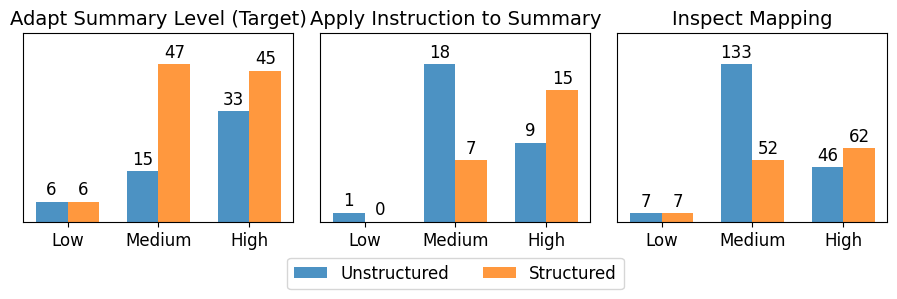

In [21]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams.update({
    "font.size": 12,
    "axes.labelsize": 14,
    "axes.titlesize": 14,
    "legend.fontsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
})

def plot_grouped_bar(df, x_col, hue_col, count_col, ax, title):
    # Keep only valid rows
    df = df.dropna(subset=[x_col, hue_col])
    x_vals = ['low', 'medium', 'high']
    hue_vals = ['unstructured', 'structured']  # enforce left=unstructured, right=structured

    # Pivot for grouped bar plot
    pivot = df.pivot_table(index=x_col, columns=hue_col, values=count_col, fill_value=0)
    for x in x_vals:
        if x not in pivot.index:
            pivot.loc[x] = [0] * len(pivot.columns)
    for h in hue_vals:
        if h not in pivot.columns:
            pivot[h] = 0
    pivot = pivot.loc[x_vals, hue_vals]

    # Plot grouped bars with opacity
    bar_width = 0.35
    x = np.arange(len(x_vals))
    bars_unstructured = ax.bar(x - bar_width/2, pivot['unstructured'], width=bar_width, label='Unstructured', alpha=0.8)
    bars_structured = ax.bar(x + bar_width/2, pivot['structured'], width=bar_width, label='Structured', alpha=0.8)

    # X labels
    ax.set_xticks(x)
    ax.set_xticklabels(['Low', 'Medium', 'High'])
    ax.set_title(title)

    # Remove y-axis ticks and labels for minimalist style
    ax.set_ylabel("")
    ax.set_yticks([])

    # Disable vertical grid lines
    ax.grid(axis="x", visible=False)

    # Set ylim automatically for each subplot
    ymax = max(pivot['unstructured'].max(), pivot['structured'].max())
    ax.set_ylim(0, ymax * 1.2)

    # Add counts above bars
    for bars in [bars_unstructured, bars_structured]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, height + ymax*0.02,
                    f"{int(height)}", ha='center', va='bottom', fontsize=12)

    return bars_unstructured, bars_structured

fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharey=False)

# Change Summary
df1 = change_summary_counts.copy()
df1['structured'] = df1['after_structured']
df1['detail_level'] = df1['after_detail_level']
bars1 = plot_grouped_bar(df1, 'detail_level', 'structured', 'count', axes[0], 'Adapt Summary Level (Target)')

# Apply Instruction
df2 = apply_instruction_counts.copy()
df2['detail_level'] = df2['detail_level']
bars2 = plot_grouped_bar(df2, 'detail_level', 'structured', 'count', axes[1], 'Apply Instruction to Summary')

# Inspect Mapping
df3 = inspect_mapping_counts.copy()
df3['structured'] = df3['structured_type']
df3['detail_level'] = df3['detail_level']
bars3 = plot_grouped_bar(df3, 'detail_level', 'structured', 'count', axes[2], 'Inspect Mapping')

# Shared legend at the top, with frame (default box)
handles = [bars1[0], bars1[1]]
labels = ['Unstructured', 'Structured']
fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.1), frameon=True)

plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.subplots_adjust(wspace=0.1)
plt.savefig('figures/interaction_bar_charts.svg', bbox_inches='tight')
plt.show()

In [22]:
backend_naturaledit_df = df_all[(df_all['source'] == 'backend') & (df_all['condition'] == 'naturaledit')].reset_index(drop=True)
apply_instruction_summary_df = backend_naturaledit_df[backend_naturaledit_df['event'] == 'apply_instruction_summary'].reset_index(drop=True)
apply_instruction_summary_df
# Extract 'instruction', 'original_summary', and 'updated_summary' from the 'data' column
apply_instruction_summary_df_extracted = apply_instruction_summary_df.apply(lambda row: pd.Series({
    'instruction': row['data'].get('instruction') if isinstance(row['data'], dict) else None,
    'original_summary': row['data'].get('original_summary') if isinstance(row['data'], dict) else None,
    'updated_summary': row['data'].get('updated_summary') if isinstance(row['data'], dict) else None
}), axis=1)

In [23]:
import difflib

def word_diff(a, b):
    """
    Compute word-level diff between two strings using difflib.SequenceMatcher.
    Returns a list of tuples: (tag, a_words, b_words)
    """
    a_words = a.split() if isinstance(a, str) else []
    b_words = b.split() if isinstance(b, str) else []
    matcher = difflib.SequenceMatcher(None, a_words, b_words)
    diff = []
    for tag, i1, i2, j1, j2 in matcher.get_opcodes():
        diff.append((tag, a_words[i1:i2], b_words[j1:j2]))
    return diff

# Calculate word diffs for each row
apply_instruction_summary_df_extracted['summary_word_diff'] = apply_instruction_summary_df_extracted.apply(
    lambda row: word_diff(row['original_summary'], row['updated_summary']), axis=1)
apply_instruction_summary_df_extracted['instruction_word_diff'] = apply_instruction_summary_df_extracted.apply(
    lambda row: word_diff(row['instruction'], ""), axis=1)

# Display the DataFrame with word diffs
apply_instruction_summary_df_extracted
# Count the number of word differences for each row

def count_word_diff(diff):
    # Count the number of words that are replaced, inserted, or deleted
    count = 0
    for tag, a_words, b_words in diff:
        if tag in ['replace', 'delete', 'insert']:
            count += max(len(a_words), len(b_words))
    return count

apply_instruction_summary_df_extracted['summary_word_diff_count'] = apply_instruction_summary_df_extracted['summary_word_diff'].apply(count_word_diff)
apply_instruction_summary_df_extracted['instruction_word_diff_count'] = apply_instruction_summary_df_extracted['instruction_word_diff'].apply(count_word_diff)

/var/folders/cx/hz4b291d7yxgb1bfmb1ksyym0000gn/T/ipykernel_71849/2457595784.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(


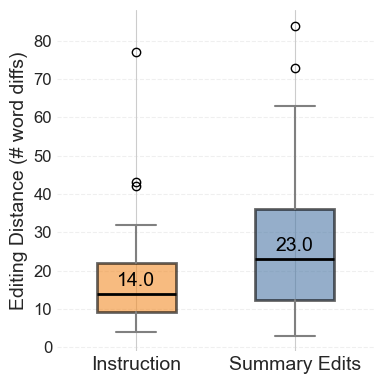

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare data
counts_data = [
    apply_instruction_summary_df_extracted["instruction_word_diff_count"].dropna(),
    apply_instruction_summary_df_extracted["summary_word_diff_count"].dropna(),
]
labels = ["Instruction", "Summary Edits"]

plt.style.use("seaborn-v0_8-whitegrid")  # clean white background
plt.figure(figsize=(4, 4))

# Custom colors: orange for first, blue for second
colors = ["#f28e2b", "#4e79a7"]

# Draw boxplot
bp = plt.boxplot(
    counts_data,
    labels=labels,
    patch_artist=True,
    widths=0.5,
    medianprops=dict(color="black", linewidth=2),
    whiskerprops=dict(color="gray", linewidth=1.5),
    capprops=dict(color="gray", linewidth=1.5),
)

# Apply different colors to each box
for patch, color in zip(bp["boxes"], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)
    patch.set_linewidth(2)

# Add median value text above each box
for median_line, data in zip(bp["medians"], counts_data):
    median_val = np.median(data)
    x = np.mean(median_line.get_xdata())
    y = np.mean(median_line.get_ydata())
    plt.text(
        x,
        y + 1,
        f"{median_val:.1f}",
        ha="center",
        va="bottom",
        fontsize=14,
        color="black",
    )

# Axis labels and ticks
plt.ylabel("Editing Distance (# word diffs)", fontsize=14)
plt.xticks(fontsize=14)
plt.grid(axis="y", linestyle="--", alpha=0.3)

# Remove all spines for minimalist style
for spine in ["top", "right", "left", "bottom"]:
    plt.gca().spines[spine].set_visible(False)

plt.tight_layout()
plt.savefig("figures/word_diff_boxplot.pdf", bbox_inches="tight")
plt.show()

In [25]:
counts_data
from scipy.stats import wilcoxon
import numpy as np
stat, p = wilcoxon(counts_data[0].values, counts_data[1].values)
median_0 = np.median(counts_data[0])
median_1 = np.median(counts_data[1])
print(f"Wilcoxon statistic: {stat}, p-value: {p}")
print(f"Median of Instruction: {median_0}")
print(f"Median of Summary Edits: {median_1}")

Wilcoxon statistic: 233.5, p-value: 9.528731226532767e-05
Median of Instruction: 14.0
Median of Summary Edits: 23.0
